# PS Parallel Programming / Sheet 10
# Fabio Valentini / MN 01018782

## Exercise 1

- `./real/Makefile`: adapted to also produce an instrumented binary
- `./analysis.txt`: flat `gprof` output
- `./analysis_lines.txt`: `gprof` output with line granularity

**Note**: Compilation and execution of instrumented binary was done on my local system, not on LCC2.

Copied from `analysis.txt`:

```
Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  ms/call  ms/call  name    
 37.79      1.02     1.02      147     6.94     7.06  resid
 22.23      1.62     0.60   131072     0.00     0.00  vranlc
 17.78      2.10     0.48      147     3.27     3.38  psinv
 10.74      2.39     0.29      147     1.97     2.08  rprj3
  7.41      2.59     0.20      147     1.36     1.36  interp
  1.85      2.64     0.05      487     0.10     0.10  comm3.constprop.0
  1.85      2.69     0.05                             norm2u3
  0.37      2.70     0.01                             zran3.constprop.0
  0.00      2.70     0.00   131642     0.00     0.00  randlc
  0.00      2.70     0.00        6     0.00     0.00  power.constprop.0
  0.00      2.70     0.00        4     0.00     0.00  wtime_
```

- `resid`: This function takes up both the biggest fraction of the total execution time, as well as the longest time for an average single function call, which should make it a good target for optimization or parallelization.

- `vranlc`: This function only takes the second place in the fraction of total execution time, because the function is called over 100,000 times, but each call takes less than 0.00 ms each (or at least, below the sampling threshold). Unless the number of function calls can be reduced, it would probably be hard to optimize it.

- `psinv`: This is the function with the second longest execution time for a single call, and also makes up the biggest fraction of the program's total execution time after `resid`, might also be a good target for parallelization.

- `rprj3`, `interp`: Have similar metrics as `psinv`, but only make up 10% or less of the total execution time of the program, so even heavy optimization would not improve execution time of the whole program by much.

The remaining functions amount to a very small fraction of the total execution time of the program - less than 5%, so parallelizing them is probably not worth it.

Copied from `analysis_lines.txt`:

```
Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
  5.93      0.16     0.16                             resid (real.c:526 @ 405b8a)
  3.52      0.26     0.10                             resid (real.c:530 @ 405ce9)
  3.33      0.35     0.09                             vranlc (randdp.c:129 @ 4021e4)
  3.33      0.44     0.09                             resid (real.c:538 @ 405d32)
  3.33      0.53     0.09                             vranlc (randdp.c:132 @ 40220c)
  2.96      0.61     0.08                             psinv (real.c:468 @ 406828)
  2.59      0.68     0.07                             resid (real.c:526 @ 405b72)
  2.59      0.75     0.07                             resid (real.c:530 @ 405d2a)
  2.59      0.82     0.07                             resid (real.c:529 @ 405d3e)
  2.59      0.89     0.07                             vranlc (randdp.c:130 @ 4021ec)
  2.41      0.95     0.07                             vranlc (randdp.c:135 @ 402230)
  2.22      1.01     0.06                             rprj3 (real.c:607 @ 407500)
[...]
```

Since `resid`, `vranlc`, `psinv`, and `rprj3` are already the four function calls that take up most of the execution time of the program by far, it is not surpsising that analysis based on lines of code also shows that the statements that take the longest are in those four functions.

However, the line numbers show that most of the time is indeed spent inside

- the two triply-nested loops in `resid` (e.g. lines 526, 529, 530, and 538 in real.c),
- a single, flat, apparently non-parallelizable loop in `vranlc` (line 129 in randdp.c), and
- a triply-nested loop in `psinv` (line 468 in real.c).

Other deeply nested loop constructs also appear in this list with relatively high fractions of total execution times, for example another triply-nested loop in `rprj3` (line 607 in real.c).

According to comments in `real.c`, at least some of the loops that contribute much to the total execution time of the program should vectorize and / or parallelize, so those will be a good first target for optimizing performance of the program.

## Exercise 2

- original implementation left as `real.c`
- parallelized version in `real_omp.c`
- Makefile adapted accordingly

Four functions were selected as targets for parallelization:

- `resid`
- `psinv`
- `rprj3`
- `interp`

All four have triply-nested loops, each of which contributes significantly to the runtime of the whole program.

However, naively parallelizing those four loop nests did not work - in all four cases, the code is structured in a way to minimize allocations for temporary partial results. The only way to keep this working without completely rewriting the algorithms used for the calculations was to make copies of those temporary partial results for each thread, resulting in a small memory allocation overhead. This is probably the reason why the parallelization does not scale well for thread counts higher than 4.

The parallelized version of the program was profiled as well, to at least confirm that calls of the parallelized functions amount to a smaller fraction of the total runtime of the program:

- `analysis_omp.txt`: flat `gprof` output
- `analysis_omp_lines.txt`: `gprof` output with line granularity

Copied from `analysis_omp.txt` for a run with `OMP_NUM_THREADS=4`:

```
Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  us/call  us/call  name    
 87.13      4.39     4.39                             setup
 11.91      4.99     0.60   131072     4.58     4.58  vranlc
  0.40      5.01     0.02                             norm2u3
  0.40      5.03     0.02                             zran3.constprop.0
  0.20      5.04     0.01      487    20.54    20.54  comm3.constprop.0
  0.00      5.04     0.00   131642     0.00     0.00  randlc
  0.00      5.04     0.00      147     0.00     0.00  interp
  0.00      5.04     0.00      147     0.00    23.47  psinv
  0.00      5.04     0.00      147     0.00    23.75  resid
  0.00      5.04     0.00        6     0.00     0.00  power.constprop.0
```

The four optimized functions only contribute a small amout to the total runtime of the program, with the `setup` function and the non-parallelizable `vranlc` function now taking the two top spots with a big margin.

The `setup` function does not look like a worthwhile target for parallelization, because it is mostly sequential code, with three loops that only have 8 iterations in the default case.

Copied from `analysis_omp_lines.txt` for a fun with `OMP_NUM_THREADS=4`:

```
Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
 15.18      0.77     0.77                             resid._omp_fn.0 (real_omp.c:544 @ 405861)
  6.25      1.08     0.32                             resid._omp_fn.0 (real_omp.c:543 @ 4058b5)
  5.56      1.36     0.28                             resid._omp_fn.0 (real_omp.c:540 @ 4056da)
  5.36      1.63     0.27                             resid._omp_fn.0 (real_omp.c:542 @ 4058b9)
  4.17      1.84     0.21                             interp._omp_fn.0 (real_omp.c:720 @ 4046dc)
  3.77      2.03     0.19                             interp._omp_fn.0 (real_omp.c:708 @ 4044e6)
  3.77      2.22     0.19                             psinv._omp_fn.0 (real_omp.c:469 @ 404d43)
  3.37      2.39     0.17                             psinv._omp_fn.0 (real_omp.c:471 @ 404d39)
  2.78      2.53     0.14                             psinv._omp_fn.0 (real_omp.c:475 @ 404ed8)
  2.58      2.66     0.13                             rprj3._omp_fn.0 (real_omp.c:625 @ 403500)
  2.48      2.79     0.13                             vranlc (randdp.c:132 @ 40224c)
  2.18      2.90     0.11                             rprj3._omp_fn.0 (real_omp.c:628 @ 403580)
  1.89      2.99     0.10                             vranlc (randdp.c:135 @ 402270)
```

The per-line granularity option seems to be more accurate for OpenMP-enabled code. Parallelized sections show up with generated function names, and the `resid` function still seems to be the most computationally expensive. Lines 540-544 are within the parallelized loop nest, and I suspect those lines have a memory access pattern that leads to the most cache misses (at this point, `r` and `v` are written and read, for the first time).

### Performance Measurements (Local)

In [1]:
# initial setup

import subprocess
import timeit

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 5
THREADS = 16

In [2]:
sequentials = []

for i in range(SAMPLE_SIZE):
    def runit():
        ret = subprocess.run(["./real/real"], stdout=subprocess.PIPE)
        ret.check_returncode()

    sequentials.append(timeit.timeit(runit, number=1))

sequentials_fastest = np.array(sequentials).min()

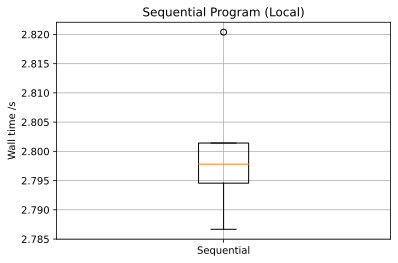

In [3]:
plt.boxplot([sequentials], labels=["Sequential"])

plt.title("Sequential Program (Local)")
plt.ylabel("Wall time /s")

plt.grid()
plt.show()

In [4]:
data = np.array([sequentials]).T
df = pd.DataFrame(data, columns=["Wall time /s"])
HTML(df.to_html(index=False))

Wall time /s
2.786667
2.820389
2.794562
2.801420
2.797808


In [5]:
parallels = []
threads = [*range(1, THREADS+1)]

for p in threads:
    def runit():
        ret = subprocess.run(
            ["./real/real_omp"],
            stdout=subprocess.PIPE,
            env={"OMP_NUM_THREADS": str(p)}
        )
        ret.check_returncode()

    parallels.append(timeit.timeit(runit, number=SAMPLE_SIZE) / SAMPLE_SIZE)

speedups = sequentials_fastest / parallels

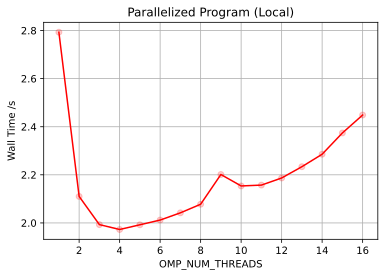

In [6]:
plt.plot(threads, parallels, "ro", alpha=0.2)
plt.plot(threads, parallels, "r-")

plt.title("Parallelized Program (Local)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Wall Time /s")

plt.grid()
plt.show()

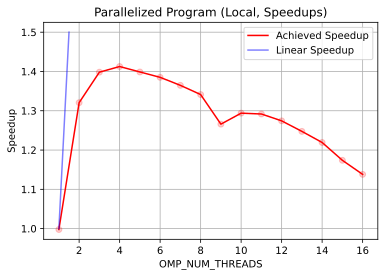

In [7]:
plt.plot(threads, speedups, "ro", alpha=0.2)
plt.plot(threads, speedups, "r-", label="Achieved Speedup")
plt.plot([1.0, 1.5], [1.0, 1.5], "b-", alpha=0.5, label="Linear Speedup")

plt.title("Parallelized Program (Local, Speedups)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

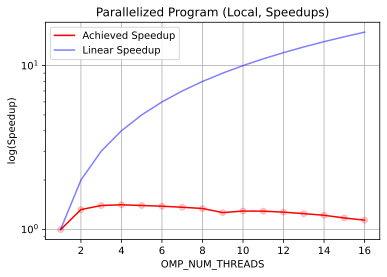

In [8]:
plt.plot(threads, speedups, "ro", alpha=0.2)
plt.plot(threads, speedups, "r-", label="Achieved Speedup")
plt.plot(threads, threads,  "b-", alpha=0.5, label="Linear Speedup")

plt.title("Parallelized Program (Local, Speedups)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("log(Speedup)")
plt.yscale("log")

plt.legend()
plt.grid()
plt.show()

In [9]:
data = np.array([threads, parallels, speedups]).T
df = pd.DataFrame(data, columns=["OMP_NUM_THREADS", "Wall time /s", "Speedup"])
HTML(df.to_html(index=False))

OMP_NUM_THREADS,Wall time /s,Speedup
1.0,2.793012,0.997728
2.0,2.110148,1.320603
3.0,1.992935,1.398273
4.0,1.972694,1.412620
5.0,1.992218,1.398776
6.0,2.011890,1.385099
7.0,2.041997,1.364677
8.0,2.077631,1.341271
9.0,2.201297,1.265920
10.0,2.153700,1.293897


### Performance Measurements (LCC2)

- `sheet_10.job.sh`
- `sheet_10.dat`

In [10]:
sequentials_lcc2 = [
    17.34,
    17.32,
    17.33,
    17.33,
    17.34,
]

sequentials_lcc2_fastest = np.array(sequentials_lcc2).min()

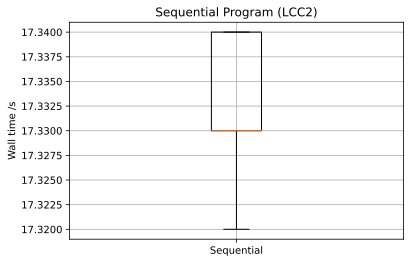

In [11]:
plt.boxplot([sequentials_lcc2], labels=["Sequential"])

plt.title("Sequential Program (LCC2)")
plt.ylabel("Wall time /s")

plt.grid()
plt.show()

In [12]:
threads_lcc2 = [1, 2, 4, 8]

parallels_lcc2 = [
    np.mean(np.array([17.31, 17.31, 17.31, 17.31, 17.39])),
    np.mean(np.array([10.59, 10.58, 10.59, 10.58, 10.59])),
    np.mean(np.array([ 9.07,  9.67,  9.07,  9.07,  9.07])),
    np.mean(np.array([10.19, 10.22, 10.21, 10.20, 10.21])),
]

speedups_lcc2 = sequentials_lcc2_fastest / parallels_lcc2

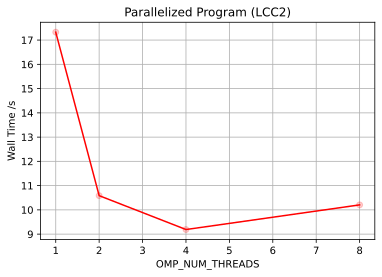

In [13]:
plt.plot(threads_lcc2, parallels_lcc2, "ro", alpha=0.2)
plt.plot(threads_lcc2, parallels_lcc2, "r-")

plt.title("Parallelized Program (LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Wall Time /s")

plt.grid()
plt.show()

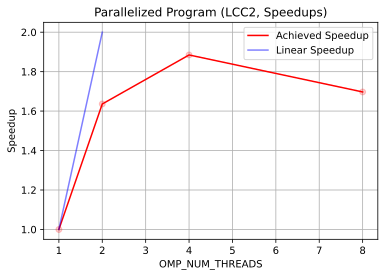

In [14]:
plt.plot(threads_lcc2, speedups_lcc2, "ro", alpha=0.2)
plt.plot(threads_lcc2, speedups_lcc2, "r-", label="Achieved Speedup")
plt.plot([1.0, 2.0], [1.0, 2.0], "b-", alpha=0.5, label="Linear Speedup")

plt.title("Parallelized Program (LCC2, Speedups)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

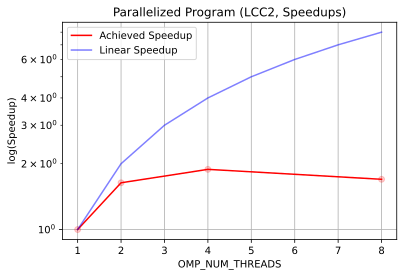

In [15]:
plt.plot(threads_lcc2, speedups_lcc2, "ro", alpha=0.2)
plt.plot(threads_lcc2, speedups_lcc2, "r-", label="Achieved Speedup")
plt.plot(range(1, 8+1), range(1, 8+1),  "b-", alpha=0.5, label="Linear Speedup")

plt.title("Parallelized Program (LCC2, Speedups)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("log(Speedup)")
plt.yscale("log")

plt.legend()
plt.grid()
plt.show()

The results from LCC2 are very similar to measurements from my local system - the best speedup seems to be achievable for 4 threads.

In [16]:
data = np.array([threads_lcc2, parallels_lcc2, speedups_lcc2]).T
df = pd.DataFrame(data, columns=["OMP_NUM_THREADS", "Wall time (LCC2) /s", "Speedup (LCC2)"])
HTML(df.to_html(index=False))

OMP_NUM_THREADS,Wall time (LCC2) /s,Speedup (LCC2)
1.0,17.326,0.999654
2.0,10.586,1.636123
4.0,9.190,1.884657
8.0,10.206,1.697041


## Hardware + Software

- CPU: AMD Ryzen 7 5800X (8 Cores, 16 Threads)
- RAM: 4 x 8GB Gskill TridentZ 3200 MHz (CL14-14-14-34)
- OS: Fedora Workstation 34
- Compiler: `gcc (GCC) 11.1.1 20210428 (Red Hat 11.1.1-1)`
- Report: Python 3.9.5, Jupyter Notebook 6.1.6, IPython 7.20.0, ipykernel 5.4.3, numpy 1.20.1, matplotlib 3.4.2, pandas 1.2.1